## Generative Latent Replay

Experimental code to test generative latent replay on benchmark continual learning problems.

i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [3]:
from pathlib import Path

# ML imports
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchinfo import summary
from avalanche.benchmarks.classic import RotatedMNIST, PermutedMNIST

# Local imports
from src import utils, plotting, models

# Continual Learning strategies
from avalanche.training import Naive, Replay, plugins
from src.strategies import LatentReplay, GenerativeLatentReplay

/home/scat5356/miniconda3/envs/env-glr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup

In [2]:
# Reproducibility
SEED = 43769
utils.set_seed(SEED)

# Reporting
eval_rate = 1

Problem definition

In [3]:
# Number of tasks
n_experiences = 3

# Transform data to format expected by model
transform = utils.get_transforms(resize=244, n_channels=3, normalise=True)

# Load dataset
experiences = PermutedMNIST(
    n_experiences=n_experiences,
    train_transform=transform,
    eval_transform=transform,
    seed=SEED,
    # rotations_list=[0, 60, 300],
)

# Train and test streams
train_stream = experiences.train_stream
test_stream = experiences.test_stream


Hyperparameters

In [4]:
# Replays
replay_buffer_size = 6000

# Frozen backbone
freeze_depth = 5
latent_layer_number = freeze_depth * 3 + 1

# SGD hyperparams
sgd_kwargs = {
    "lr": 0.001, #0.1,  # 0.001
    "momentum": 0.9,
    "weight_decay": 0.0005, #l2 regularization
}

strategy_kwargs = {
    "eval_every": eval_rate,
    "train_epochs": 40,
    "train_mb_size": 64,
    "eval_mb_size": 128,
    "device": utils.get_device(),
    "plugins": [
        plugins.EarlyStoppingPlugin(
            patience=eval_rate,
            val_stream_name="train_stream/Task000",
            margin=0.003,  # metric
        )
    ],
}


Building base model

In [5]:
# Model
model_lr = models.alexnet()
model_glr = models.alexnet()
model_naive = models.alexnet()
model_replay = models.alexnet()

Loading Continual Learning strategies for experiments

Training loop

In [ ]:
strategy_lr = LatentReplay(
    model=model_lr,
    rm_sz=replay_buffer_size,
    latent_layer_num=latent_layer_number,
    evaluator=utils.get_eval_plugin("Latent Replay"),
    **strategy_kwargs,
    **sgd_kwargs,
)

#print(strategy_lr.model)
#print(model_lr)
#batch_size = 16
#summary(strategy_lr.model, input_size=(1, *experiences.train_stream[0].dataset[0][0].shape))

# eval_streams=[train_exp] to get validation on current experience (minus replays?)
for train_exp in train_stream:
    strategy_lr.train(train_exp) #, eval_streams=[train_exp])
    strategy_lr.eval(train_stream)
    utils.save_model(strategy_lr.model, Path("results/Latent Replay"), f"model_{train_exp.current_experience}.pt")

utils.close_loggers(strategy_lr)

In [ ]:
# Loading GLR model
strategy_glr = GenerativeLatentReplay(
    model=model_glr,
    rm_sz=replay_buffer_size,
    latent_layer_num=latent_layer_number,
    evaluator=utils.get_eval_plugin("GLR"),
    **strategy_kwargs,
    **sgd_kwargs,
)

# eval_streams=[train_exp] to get validation on current experience (minus replays?)
for train_exp in train_stream:
    strategy_glr.train(train_exp) #, eval_streams=[train_exp])
    strategy_glr.eval(train_stream)
    utils.save_model(strategy_glr.model, Path("results/GLR"), f"model_{train_exp.current_experience}.pt")

utils.close_loggers(strategy_glr)

In [ ]:
# Loading baseline (naive) model
strategy_naive = Naive(
    model=model_naive,
    optimizer=SGD(model_naive.parameters(), **sgd_kwargs),
    evaluator=utils.get_eval_plugin("Naive"),
    **strategy_kwargs,
)

for train_exp in train_stream:
    strategy_naive.train(train_exp, eval_streams=[train_exp])
    strategy_naive.eval(train_stream)
    utils.save_model(strategy_naive.model, Path("results/Naive"), f"model_{train_exp.current_experience}.pt")

utils.close_loggers(strategy_naive)

In [ ]:
summary(model_glr, input_size=(1, *experiences.train_stream[0].dataset[0][0].shape))

In [ ]:
n_classes = 10
n_samples = 60000
dim = 9216
sampler = models.GMM(n_classes=n_classes)
x = torch.rand(n_samples, dim).detach().cpu().numpy()
y = torch.randint(0, n_classes, (n_samples,)).detach().cpu().numpy()
#sampler.train(x, y)
print(x.dtype, y.dtype)

In [ ]:
# Loading benchmark (replay) model
strategy_replay = Replay(
    model=model_replay,
    criterion=CrossEntropyLoss(),
    optimizer=SGD(model_replay.parameters(), **sgd_kwargs),
    evaluator=utils.get_eval_plugin("Replay"),
    **strategy_kwargs,
)

for train_exp in train_stream:
    strategy_replay.train(train_exp, eval_streams=[train_exp])
    strategy_replay.eval(train_stream)
    utils.save_model(strategy_replay.model, Path("results/Replay"), f"model_{train_exp.current_experience}.pt")

utils.close_loggers(strategy_replay)

Plotting

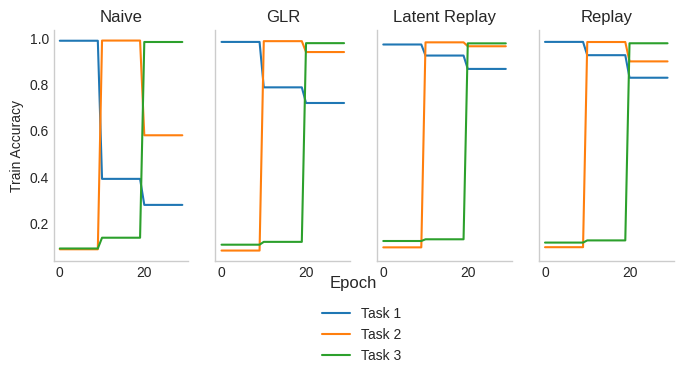

In [9]:
#import importlib; importlib.reload(plotting)
plotting.plot_multiple_results()

In [5]:
plotting.results_to_df()

/home/scat5356/miniconda3/envs/env-glr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/scat5356/miniconda3/envs/env-glr/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Final Avg Acc,Final Avg Loss
Naive,nan,nan
Latent Replay,0.934867,0.221533
GLR,0.877833,0.384867
Replay,0.900567,0.329100
